In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import welch
from scipy.stats import circstd  # type: ignore
from tqdm import trange

from kalman_experiments import SSPE
from kalman_experiments.kalman.wrappers import PerturbedP1DMatsudaKF, apply_kf
from kalman_experiments.model_selection import (
    estimate_sigmas,
    fit_kf_parameters,
    get_psd_val_from_est,
)
from kalman_experiments.models import (
    ArNoiseModel,
    MatsudaParams,
    SingleRhythmModel,
    gen_ar_noise_coefficients,
)

In [3]:
# Generate data
SRATE = 1000
DURATION = 10_00
CHUNK_NSAMP = int(10 * SRATE)
FREQ_GT = 6
SIGNAL_SIGMA_GT = np.sqrt(10)
NOISE_SIGMA_GT = 1
A_GT = 0.99
ALPHA = 1.5
NOISE_AR_ORDER = 1000
sim = dict(
    sines_in_white=SSPE.gen_sine_w_white(DURATION, SRATE),
    sines_in_pink=SSPE.gen_sine_w_pink(DURATION, SRATE),
    filtered_pink=SSPE.gen_filt_pink_noise_w_added_pink_noise(DURATION, SRATE),
    state_space_model_white=SSPE.gen_state_space_model_white(DURATION, SRATE),
    state_space_model_pink=SSPE.gen_state_space_model_pink(DURATION, SRATE),
)

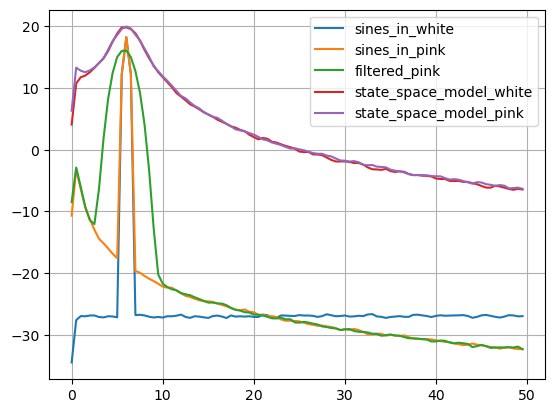

In [4]:
# Plot PSD for generated data
FREQ_LIM = 100
plt.figure()
for k, s in sim.items():
    freqs, psd = welch(s.data, fs=SRATE, nperseg=2000)
    plt.plot(freqs[:FREQ_LIM], 10 * np.log10(psd[:FREQ_LIM]), label=k)
plt.grid()
plt.legend()
plt.show()

In [5]:
TRAIN_LIMIT_SAMP = 5000
KF_NOISE_ORDER = 30
NPERSEG = 1000


def fit_parameters(
    train_data: np.ndarray,
    mp_init: MatsudaParams,
    noise_alpha: float,
    noise_order: int,
    nperseg: int,
) -> PerturbedP1DMatsudaKF:
    freqs, psd = welch(train_data, fs=mp_init.sr, nperseg=nperseg)
    est_psd_func = partial(get_psd_val_from_est, freqs=freqs, psd=psd)
    psi = gen_ar_noise_coefficients(noise_alpha, noise_order)

    # ar_psd_func = partial(theor_psd_ar, ar_coef=psi, sr=SRATE, s=1)
    ar_psd_func = ArNoiseModel(
        np.random.randn(noise_order),
        sr=mp_init.sr,
        order=noise_order,
        alpha=noise_alpha,
        sigma=1,
    ).psd_onesided
    mar_psd_func = SingleRhythmModel(mp_init, sigma=1).psd_onesided

    q_s_2, r_s_2 = estimate_sigmas([mar_psd_func, ar_psd_func], est_psd_func, fit_freqs)
    q_s_est, r_s_est = np.sqrt(q_s_2), np.sqrt(r_s_2)
    r_s_est, q_s_est = max(r_s_est, 0.0001), max(q_s_est, 0.01)
    print(f"{q_s_est=:.4f}, {r_s_est=:.4f}")

    psi = gen_ar_noise_coefficients(alpha=noise_alpha, order=noise_order)
    kf = PerturbedP1DMatsudaKF(mp_init, q_s=q_s_est, psi=psi, r_s=r_s_est)
    return fit_kf_parameters(train_data, kf, tol=1e-3)


fit_freqs = [6, 450]
cstd_pink = {}
cstd_white = {}
params_pink = {}
params_white = {}

for k, s in sim.items():
    # if k != "sines_in_pink":
    #     continue

    if k != "filtered_pink":
        continue
    print(f"{k:-^80}")
    train_data = s.data[:TRAIN_LIMIT_SAMP]

    # pink noise
    A_fit = 0.99
    if k.startswith("sines"):
        A_fit = 0.99999
    elif k.startswith("filtered"):
        A_fit = 0.995
    alpha, order = (ALPHA, KF_NOISE_ORDER) if k.endswith("pink") else (0, 1)

    mp_init = MatsudaParams(A_fit, freq=FREQ_GT, sr=SRATE)

    kf_pink_fit = fit_parameters(train_data, mp_init, alpha, order, nperseg=NPERSEG)
    params_pink[k] = (kf_pink_fit.mp.A, kf_pink_fit.mp.freq, kf_pink_fit.q_s, kf_pink_fit.r_s)

    kf_white_fit = fit_parameters(
        train_data, mp_init, noise_alpha=0, noise_order=1, nperseg=NPERSEG
    )
    params_white[k] = (kf_white_fit.mp.A, kf_white_fit.mp.freq, kf_white_fit.q_s, kf_white_fit.r_s)

    cstd_pink[k] = []
    cstd_white[k] = []
    for i in trange(int(DURATION / 10)):
        data_chunk = s.data[i * CHUNK_NSAMP : (i + 1) * CHUNK_NSAMP]
        phases_chunk = s.true_phase[i * CHUNK_NSAMP : (i + 1) * CHUNK_NSAMP]

        filtered_pink = apply_kf(kf_pink_fit, data_chunk, delay=0)
        filtered_white = apply_kf(kf_white_fit, data_chunk, delay=0)
        #         filtered_white = apply_kf(kf_white, data_chunk, delay=0)

        cstd_pink[k].append(circstd(np.angle(filtered_pink) - phases_chunk) * 180 / np.pi)
        cstd_white[k].append(circstd(np.angle(filtered_white) - phases_chunk) * 180 / np.pi)

    print("circstd stats:")
    print(f"pink:  mean={np.mean(cstd_pink[k]):.4f}, std={np.std(cstd_pink[k]):.4f}")
    print(f"white: mean={np.mean(cstd_white[k]):.4f}, std={np.std(cstd_white[k]):.4f}")

---------------------------------sines_in_pink----------------------------------
q_s_est=1.30e-03, r_s_est=1.42e-01


Fitting KF parameters: nll=-4802.32,f=6.01, A=0.9999, 0.0019, 0.21:   0%| | 4/800 [00:04


q_s_est=1.30e-03, r_s_est=8.51e-02


Fitting KF parameters: nll=390748.05,f=6.00, A=1.0000, 0.0045, 1.02:   0%| | 0/800 [00:0
100%|█████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s]

circstd stats:
pink:  mean=0.2783, std=0.1835
white: mean=0.9146, std=0.4136


In [11]:
def grouped_barplot(df, cat, subcat, val, err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx)) - np.arange(len(subx)).mean()) / (len(subx) + 1.0)
    width = np.diff(offsets).mean()
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(
            x + offsets[i],
            dfg[val].values,
            width=width,
            label="{} {}".format(subcat, gr),
            yerr=dfg[err].values,
        )
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()
    plt.show()


cat = "Candidate"
subcat = "Sample_Set"
val = "Values"
err = "Error"

# call the function with df from the question
df_pink = pd.DataFrame(cstd_pink)
df_pink = df_pink.T.unstack().reset_index()
df_pink["algorithm"] = "pink kf"
df_pink = df_pink.rename(
    columns={"level_0": "trial_num", "level_1": "simulation", 0: "circular std"}
)

df_white = pd.DataFrame(cstd_white)
df_white = df_white.T.unstack().reset_index()
df_white["algorithm"] = "white kf"
df_white = df_white.rename(
    columns={"level_0": "trial_num", "level_1": "simulation", 0: "circular std"}
)

df = pd.concat([df_pink, df_white])

fig = plt.figure(figsize=(15, 10))
sns.boxplot(df, hue="algorithm", x="simulation", y="circular std")
plt.ylim([0, 100])
plt.grid()
plt.show()

array([[ 4.98041326e-03,  1.58136704e-05, -4.97941326e-03, ...,
        -2.59286591e-03, -2.43212962e-03, -2.26807019e-03],
       [ 1.58136704e-05,  5.01175020e-03, -1.58136704e-05, ...,
        -4.22534061e-03, -4.31788859e-03, -4.40420768e-03],
       [-4.97941326e-03, -1.58136704e-05,  4.98041326e-03, ...,
         2.59286591e-03,  2.43212962e-03,  2.26807019e-03],
       ...,
       [-2.59286591e-03, -4.22534061e-03,  2.59286591e-03, ...,
         4.99883601e-03,  4.96537564e-03,  4.95284976e-03],
       [-2.43212962e-03, -4.31788859e-03,  2.43212962e-03, ...,
         4.96537564e-03,  4.99861178e-03,  4.96409316e-03],
       [-2.26807019e-03, -4.40420768e-03,  2.26807019e-03, ...,
         4.95284976e-03,  4.96409316e-03,  4.99826829e-03]])

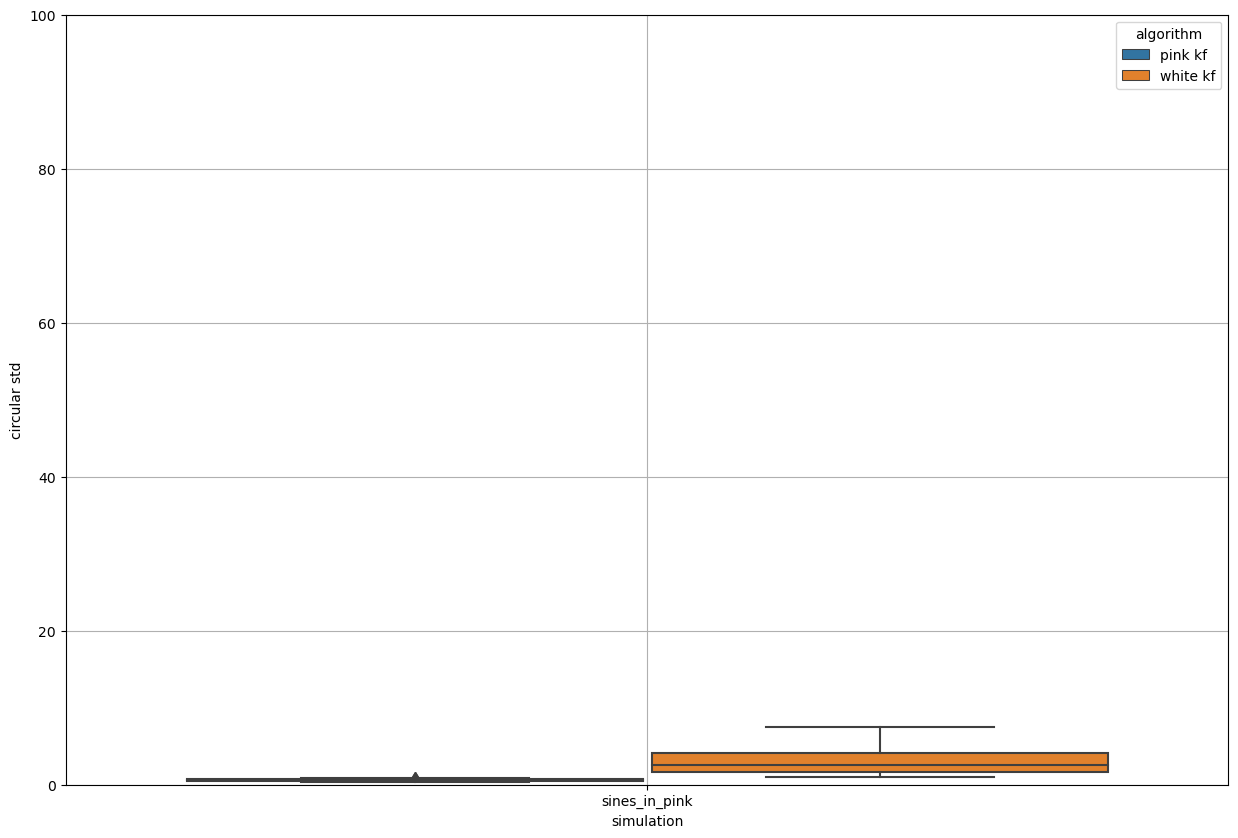

In [12]:
# df.to_csv("metrics.csv", index=False)